# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [2]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [5]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD # Importing the optimizers which can be used in our model
from keras.callbacks import ReduceLROnPlateau

from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [3]:
# Uncomment and run the below code if you are using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
images = np.load('/content/drive/MyDrive/images.npy')
labels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [7]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [18]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

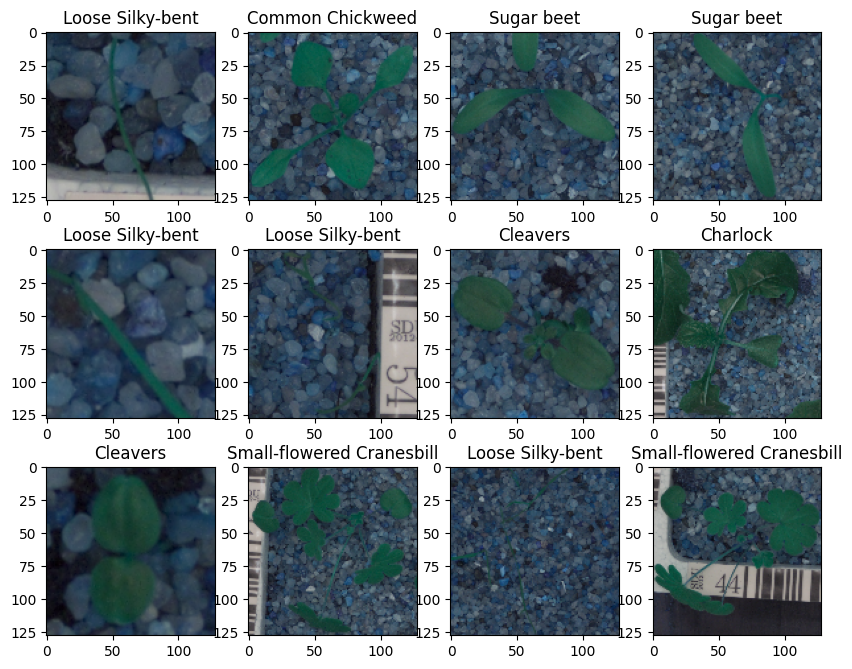

In [19]:
plot_images(images,labels)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

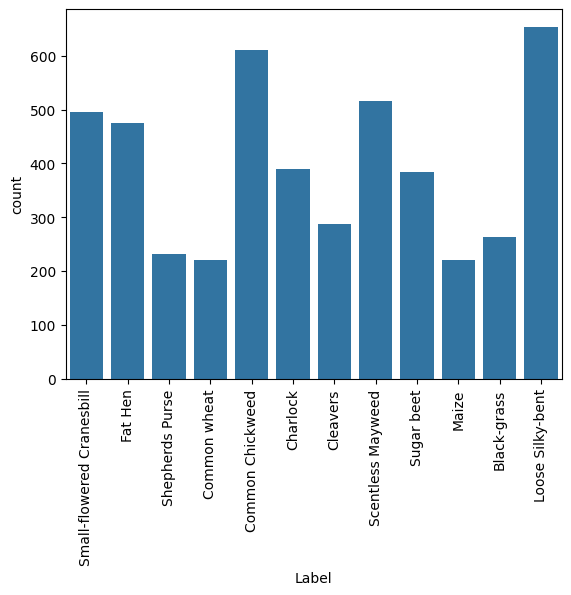

In [20]:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [21]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [22]:

images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

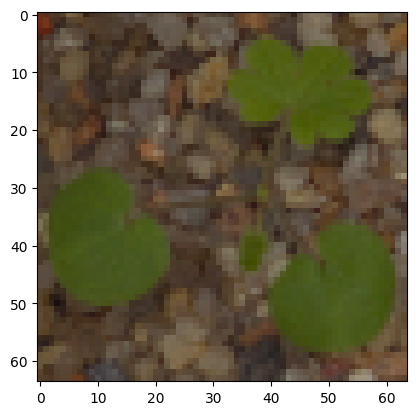

In [23]:
plt.imshow(images_decreased[8])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [24]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [25]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [26]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [27]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape

((3847, 12), (428, 12), (475, 12))

### Data Normalization

In [28]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [29]:
from tensorflow.keras import backend
backend.clear_session()

In [30]:
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [31]:
# Intializing a sequential model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Creating two similar convolution and max-pooling layers
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

opt=Adam()
# Compile model
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          32,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,828 (503.23 KB)

 Trainable params: 128,828 (503.23 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 20s - 166ms/step - accuracy: 0.1110 - loss: 2.4655 - val_accuracy: 0.1472 - val_loss: 2.4344
Epoch 2/30
121/121 - 1s - 9ms/step - accuracy: 0.2069 - loss: 2.3404 - val_accuracy: 0.2921 - val_loss: 2.1601
Epoch 3/30
121/121 - 1s - 11ms/step - accuracy: 0.2841 - loss: 2.1082 - val_accuracy: 0.3458 - val_loss: 1.9126
Epoch 4/30
121/121 - 1s - 9ms/step - accuracy: 0.3275 - loss: 1.9335 - val_accuracy: 0.3505 - val_loss: 1.7242
Epoch 5/30
121/121 - 1s - 9ms/step - accuracy: 0.3358 - loss: 1.8555 - val_accuracy: 0.3645 - val_loss: 1.6997
Epoch 6/30
121/121 - 1s - 9ms/step - accuracy: 0.3574 - loss: 1.7953 - val_accuracy: 0.3972 - val_loss: 1.6047
Epoch 7/30
121/121 - 1s - 9ms/step - accuracy: 0.3582 - loss: 1.7413 - val_accuracy: 0.4112 - val_loss: 1.5117
Epoch 8/30
121/121 - 1s - 10ms/step - accuracy: 0.3668 - loss: 1.6815 - val_accuracy: 0.3972 - val_loss: 1.5392
Epoch 9/30
121/121 - 1s - 10ms/step - accuracy: 0.3650 - loss: 1.6943 - val_accuracy: 0.4206 - val_loss: 1.

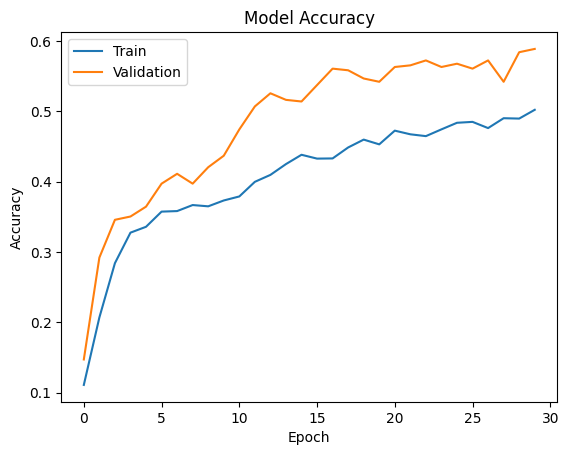

In [36]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 72ms/step - accuracy: 0.5621 - loss: 1.3053


In [38]:
y_pred=model1.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


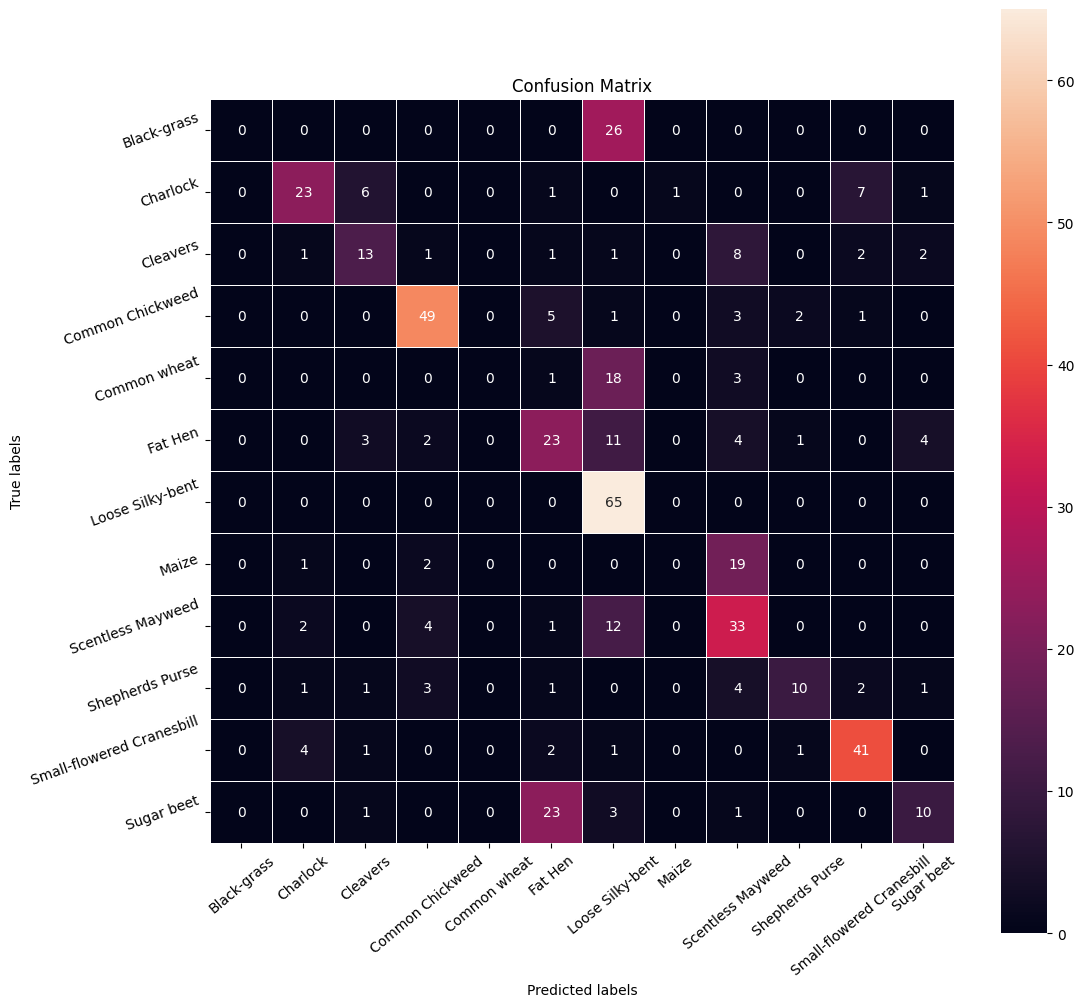

In [39]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [40]:
from sklearn import metrics
#Accuracy as per the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.72      0.59      0.65        39
           2       0.52      0.45      0.48        29
           3       0.80      0.80      0.80        61
           4       0.00      0.00      0.00        22
           5       0.40      0.48      0.43        48
           6       0.47      1.00      0.64        65
           7       0.00      0.00      0.00        22
           8       0.44      0.63      0.52        52
           9       0.71      0.43      0.54        23
          10       0.77      0.82      0.80        50
          11       0.56      0.26      0.36        38

    accuracy                           0.56       475
   macro avg       0.45      0.46      0.44       475
weighted avg       0.51      0.56      0.51       475



In [41]:
del model1
del history_1

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [43]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [44]:
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [45]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         131,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,676 (592.48 KB)

 Trainable params: 151,612 (592.23 KB)

 Non-trainable params: 64 (256.00 B)

In [46]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.1648 - loss: 2.4039 - val_accuracy: 0.1402 - val_loss: 2.4034 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2969 - loss: 1.9919 - val_accuracy: 0.1472 - val_loss: 2.4047 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.3671 - loss: 1.8764 - val_accuracy: 0.3528 - val_loss: 2.2952 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4844 - loss: 1.5380 - val_accuracy: 0.2804 - val_loss: 2.2994 - learning_rate: 0.0010
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.4640 - loss: 1.6357 - val_accuracy: 0.3832 - val_loss: 2.2133 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3906 - loss: 1.6888 - val_accuracy: 0.3271 - val_loss: 2.2229 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.5025 - loss: 1.5088 - val_accu

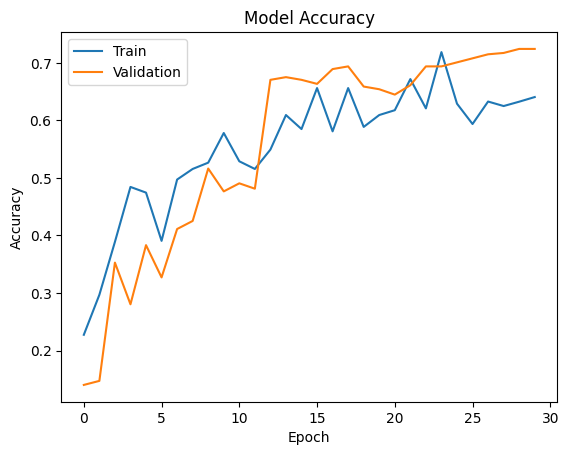

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 2s - 154ms/step - accuracy: 0.7179 - loss: 0.9117


In [49]:
y_pred=model2.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


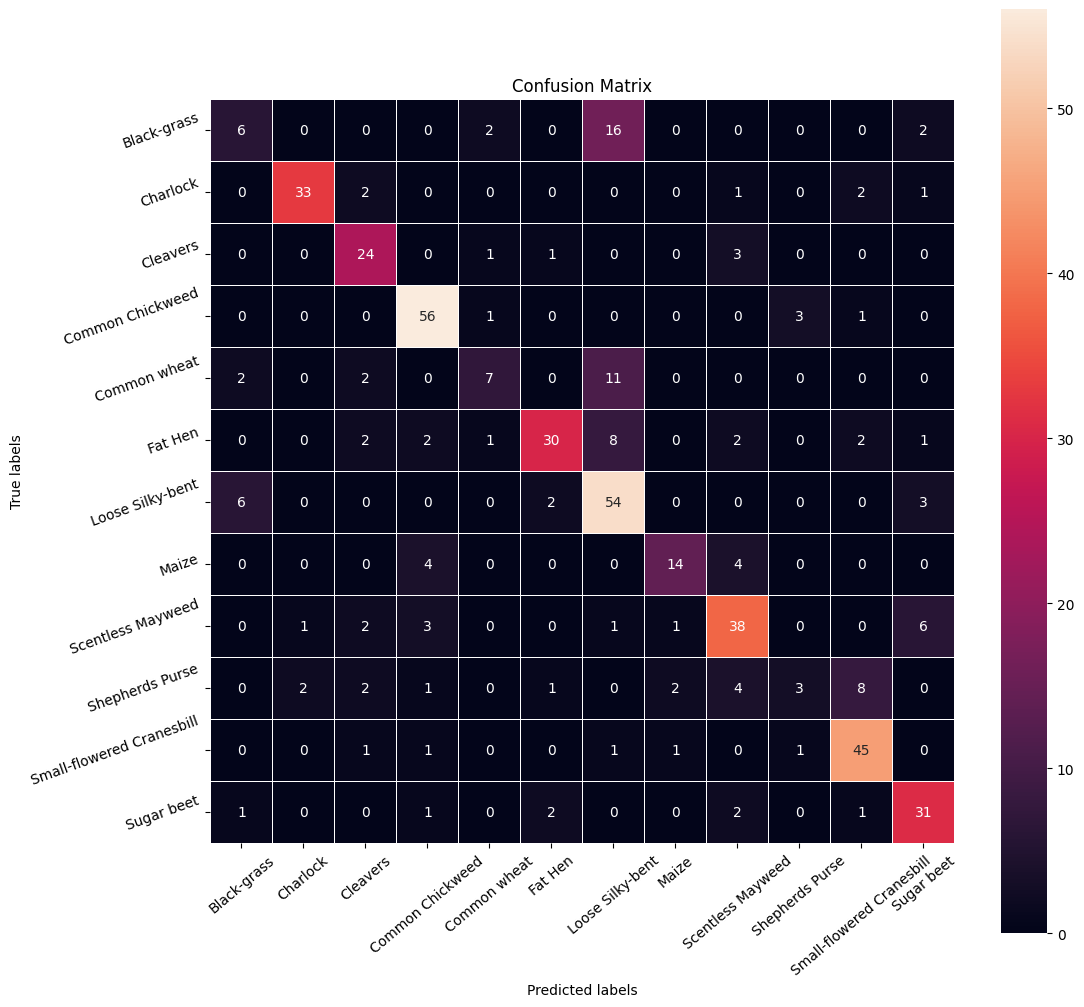

In [50]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [51]:
cr=metrics.classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.40      0.23      0.29        26
           1       0.92      0.85      0.88        39
           2       0.69      0.83      0.75        29
           3       0.82      0.92      0.87        61
           4       0.58      0.32      0.41        22
           5       0.83      0.62      0.71        48
           6       0.59      0.83      0.69        65
           7       0.78      0.64      0.70        22
           8       0.70      0.73      0.72        52
           9       0.43      0.13      0.20        23
          10       0.76      0.90      0.83        50
          11       0.70      0.82      0.76        38

    accuracy                           0.72       475
   macro avg       0.68      0.65      0.65       475
weighted avg       0.71      0.72      0.70       475



## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

In [ ]:
#model2
#higher accuracy

### Visualizing the prediction

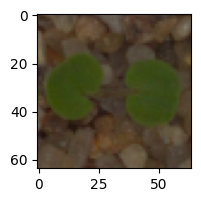

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


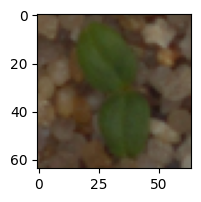

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Label ['Cleavers']
True Label Cleavers


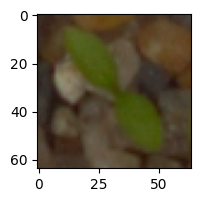

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


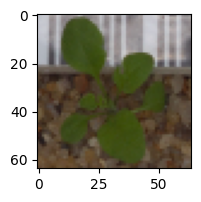

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Shepherds Purse


In [53]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Actionable Insights and Business Recommendations

*

In [54]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation'],'Train Accuracy':['44%','75%'],'Validation Accuracy':['61%','72%'],'Test Accuracy':['60%','70%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,44%,61%,60%
1,CNN Model with Data Augmentation,75%,72%,70%


Second model is better model
Train accuracy 44% (model1) vs 75% (model2)
Data Augmentation improved overall model performance

_____